In [10]:
import pandas as pd
import numpy as np
from openff.toolkit.topology import Molecule
from openff.units import unit
import seaborn as sb
from scipy import stats
import matplotlib.pyplot as plt
from rdkit.Chem import Draw
from scipy.stats import gaussian_kde
from matplotlib import cm
from matplotlib.colors import Normalize
from sklearn.metrics import r2_score
import matplotlib
import re

def density_scatter_plot(x, y, **kwargs):
    """
    :param x: data positions on the x axis
    :param y: data positions on the y axis
    :return: matplotlib.collections.PathCollection object
    """
    # Kernel Density Estimate (KDE)
    values = np.vstack((x, y))
    kernel = gaussian_kde(values)
    kde = kernel.evaluate(values)

    # create array with colors for each data point
    norm = Normalize(vmin=kde.min(), vmax=kde.max())
    colors = cm.ScalarMappable(norm=norm, cmap='viridis').to_rgba(kde)

    # override original color argument
    kwargs['color'] = colors

    return plt.scatter(x, y, **kwargs)

def equalityline(x, y, ax = None, **kwargs):
    x0, x1 = min(x), max(x)
    y0, y1 = min(y), max(y)
    lims = [min(x0, y0), max(x1, y1)]
    ax = ax or plt.gca()
    ax.plot(lims, lims, **kwargs)

def m(x, y, ax = None, **kwargs):
    
    x = np.array(x)
    y = np.array(y)
    ax = ax or plt.gca()
    m =(np.sum((x - y)**2, axis=0)/(y.shape[0]))**0.5
    ax.annotate(f'$RMSE= {float(m):.2f}$',
                xy=(.01, .99), xycoords=ax.transAxes, fontsize=8,
                color='darkred', backgroundcolor='#FFFFFF99', ha='left', va='top')   
    
def kde(x, y, ax = None, **kwargs):
    if isinstance(x, np.ndarray) and isinstance(y, np.ndarray):
        x = np.array(x)
        y = np.array(y)
    ax = ax or plt.gca()
    kernel = stats.gaussian_kde(x)(y)
    ax.scatter(x, y, c=kernel, s=5)
    
def density_scatter_plot(x, y, **kwargs):
    values = np.vstack((x, y))
    kernel = gaussian_kde(values)
    kde = kernel.evaluate(values)

    norm = Normalize(vmin=kde.min(), vmax=kde.max())
    colors = cm.ScalarMappable(norm=norm, cmap='viridis').to_rgba(kde)

    kwargs['color'] = colors

    return plt.scatter(x, y, **kwargs)

Load the dataset of the predicted and ground truth values

In [ ]:
parquet = "./test_gas_esp_model.parquet"
df_esp = pd.read_parquet(parquet)
df_esp

,mbis_charges,predicted_charges,molecule,geometry,molblock,mol_id,qm_dipoles_magnitude,mbis_dipoles_magnitude,predicted_dipoles,qm_esp,...,charge_model_esp,charge_model_esp_rmse,dipole_model_charges,dipole_model_dipoles,dipole_model_esp,dipole_model_esp_rmse,esp_model_charges,esp_model_dipoles,esp_model_esp,esp_model_esp_rmse
0,"[-0.22488003528642272, -0.1351402477596661, -0...",None,[H:16][C:3]1([C:2]2([C:1]([C:10]3([C:9]([C:6](...,"[1.25270397, -3.11433522, -0.27348176, 0.53779...",\n RDKit 3D\n\n 30 32 0 0 0 0...,def1e279243bea4f5b6495cd8f7f4345daf2d581b1cb16...,3.601982,0.377016,NaN,None,...,"[0.1457203409828285, 0.14601828110179937, 0.14...",3.585800,"[-0.23802225291728973, -0.12375437468290329, -...",3.523137e+00,"[0.1363434411230837, 0.13721806192584793, 0.13...",2.087995,"[-0.24192476272583008, -0.13747484982013702, -...",3.499248e+00,"[0.13676158656115062, 0.13758769981410143, 0.1...",2.209531
1,"[-0.33238438551204774, -0.3323754494149188, 0....",None,[H:11][C:1]1([C:2]([C:3]12[C:4]([C:5]3([C:6]24...,"[-1.33170496, -1.98458289, -4.12140476, 1.4956...",\n RDKit 3D\n\n 24 27 0 0 0 0...,d783f828d07657bf7b21f319243045c81179c8fbf25707...,0.071379,0.213495,NaN,None,...,"[-0.0028424577991436953, -0.001670851881821956...",1.085380,"[-0.33716997504234314, -0.33716997504234314, 0...",6.512916e-02,"[-0.0029810430720189902, -0.001748202061567783...",1.091506,"[-0.33932560682296753, -0.33932560682296753, 0...",5.683711e-02,"[-0.0027129110686675627, -0.001523746851158705...",1.088771
2,"[0.30152651342248465, -0.23743178438605075, -0...",None,[H:10][c:1]1[c:2]2=[C:3]([C:4]([N:5]=[c:6]2[n:...,"[3.15546607, 0.91440317, -0.09809173, 0.490575...",\n RDKit 3D\n\n 14 15 0 0 0 0...,1cef51c39f3c2bfabf3dfbd2a4e1785db48d679246bd24...,1.739315,0.301041,NaN,None,...,"[-0.008398990389559078, -0.009220112397035315,...",2.476460,"[0.2760153114795685, -0.2104046791791916, -0.1...",1.765437e+00,"[-0.010664490306502872, -0.011609281199879607,...",2.038646,"[0.26394322514533997, -0.17123880982398987, -0...",1.647688e+00,"[-0.008602471378477413, -0.00942713954759151, ...",2.120094
3,"[-0.2507532752347685, -0.05450358150607305, -0...",None,[H:11][C:1]1([C:2]2([C:3]([C:4]([C:5]1([C:6]3(...,"[0.15106329, -0.93636657, 3.16441462, -0.09645...",\n RDKit 3D\n\n 22 24 0 0 0 0...,4de7de9b4ff2bb85b055dedd6aae06047f7c8a6fb5c8d8...,0.533277,0.334996,NaN,None,...,"[-0.014190061072347755, -0.016361653218607636,...",2.210854,"[-0.22575117647647858, -0.04964722320437431, -...",5.842437e-01,"[-0.011033716389748684, -0.012610140838252367,...",1.316462,"[-0.23672281205654144, -0.03998648375272751, -...",6.428218e-01,"[-0.011823195002933246, -0.013329239945138863,...",1.383529
4,"[-0.29357569096172537, -0.2935796471919738, -0...",None,[H:4][C:1]1([C:2]([C:3]1([H:8])[H:9])([H:6])[H...,"[1.12451814, -1.34731691, 1.05257344, 3.926744...",\n RDKit 3D\n\n 9 9 0 0 0 0...,92f21c93e8e02804b7a30deeb1e8f3462f0fefc183520a...,0.000030,0.156853,NaN,None,...,"[-0.0019079738716478336, -0.001040381800826817...",1.403582,"[-0.3011597990989685, -0.3011597990989685, -0....",1.797452e-07,"[-0.0019445345018479113, -0.001060322993147705...",1.390773,"[-0.30292966961860657, -0.30292966961860657, -...",1.797844e-07,"[-0.001955950558766177, -0.0010665425742439024...",1.386931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10287,"[-0.6255876249923304, 1.4873442452131167, -0.6...",None,[O:1]=[S:2]1(=[O:3])[N:4]=[C:5]([H:13])[N:6]([...,"[-4.2667249, -3.77187093, 1.01001634, -3.39815...",\n RDKit 3D\n\n 15 16 0 0 0 0...,9f689d9f98a6ca49d4867a60aafabdff89fbb82bf13a81...,3.268596,0.404008,NaN,None,...,"[-0.03324642305523355, -0.0324117381267247, -0...",2.265183,"[-0.5809901356697083, 1.4990102052688599, -0.5...",3.204237e+00,"[-0.02762569762904282, -0.02698878713621738, -...",1.505948,"[-0.5988499522209167, 1.5164215564727783, -0.5...",3.340648e+00,"[-0.0290565662370931, -0.028375613879098455, -...",1.635578
10288,"[-1.0542912996313811, 1.8402112653415987, -1.0.

Run this over the dataframe to get errors across the set

In [4]:
def calculate_rmse_metrics_single_df(df, models):
    """
    Calculate RMSE metrics for multiple models in a single dataset.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing model predictions and reference data.
    models : list of str
        List of model names to compare.
    
    Returns
    -------
    pd.DataFrame
        Summary DataFrame containing RMSE metrics for each model.
    """
    metrics_list = []

    for model_name in models:
        # Ensure numeric columns are cleaned of NaN/Inf
        esp_rmse_col = f"{model_name}_esp_rmse"
        df[esp_rmse_col] = df[esp_rmse_col].replace([np.inf, -np.inf], np.nan).dropna()
        
        # Compute Dipole RMSE
        dipole_rmse = np.sqrt(
            np.mean(
                (df['qm_dipoles_magnitude'] - df[f"{model_name}_dipoles"].apply(np.linalg.norm)) ** 2
            )
        )
        
        # Compute Charge RMSE molecule by molecule
        charge_rmse_list = []
        for mbis, predicted in zip(df['mbis_charges'], df[f"{model_name}_charges"]):
            # Ensure both arrays have the same length and compute RMSE for this molecule
            if len(mbis) == len(predicted):
                charge_rmse_list.append(np.sqrt(np.mean((np.array(mbis) - np.array(predicted)) ** 2)))
        charge_rmse = np.mean(charge_rmse_list)  # Average RMSE over all molecules
        
        # Compute ESP RMSE
        esp_rmse = df[esp_rmse_col].mean()  # Already precomputed RMSE in the column
        
        # Append metrics for this model
        metrics_list.append({
            'Model': model_name,
            'Dipole RMSE': dipole_rmse,
            'Charge RMSE': charge_rmse,
            'ESP RMSE': esp_rmse
        })

    # Combine results into a summary DataFrame
    summary_df = pd.DataFrame(metrics_list)
    return summary_df
models = ['charge_model', 'dipole_model', 'esp_model']

# Assuming `df` contains columns like 'charge_model_charges', 'charge_model_dipoles', etc.
summary_df = calculate_rmse_metrics_single_df(df_esp, models)
print(summary_df)

          Model  Dipole RMSE  Charge RMSE  ESP RMSE
0  charge_model     0.293738     0.015496  2.380642
1  dipole_model     0.164807     0.028474  1.952594
2     esp_model     0.156994     0.030757  1.794755


In [5]:
summary_df

,Model,Dipole RMSE,Charge RMSE,ESP RMSE
0,charge_model,0.293738,0.015496,2.380642
1,dipole_model,0.164807,0.028474,1.952594
2,esp_model,0.156994,0.030757,1.794755


Gas vs Water Charges

/var/folders/8_/xls29m695yl7qglq81r94h7w0000gr/T/ipykernel_1771/2285361052.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gas_model_charges_array = np.concatenate(df_gas['esp_model_charges'])
/var/folders/8_/xls29m695yl7qglq81r94h7w0000gr/T/ipykernel_1771/2285361052.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  water_model_charges_array = np.concatenate(df_water['esp_model_charges'])


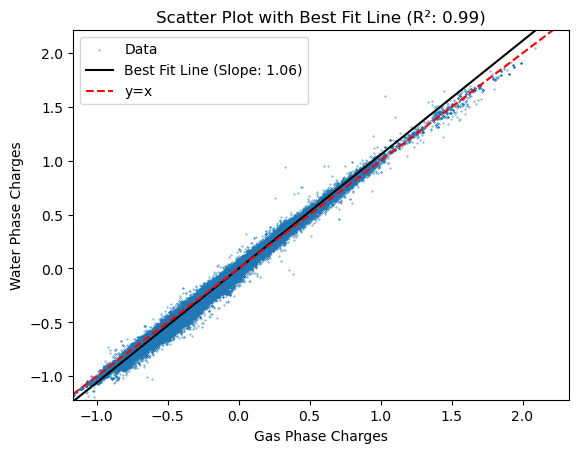

Slope of the best fit line: 1.0579137801936465
R² score: 0.9873076679149769


In [11]:
# Load data
df_water = pd.read_parquet('./test_water_esp_model.parquet') 
df_gas = pd.read_parquet('./test_gas_esp_model.parquet')

# Align indices
df_gas.set_index('molblock', inplace=True)
df_water.set_index('molblock', inplace=True)
df_water = df_water.reindex(df_gas.index)

gas_model_charges_array = np.concatenate(df_gas['esp_model_charges'])
water_model_charges_array = np.concatenate(df_water['esp_model_charges'])

# Calculate R-squared
r2 = r2_score(gas_model_charges_array, water_model_charges_array)

# Plot scatter
plt.scatter(gas_model_charges_array, water_model_charges_array, s=0.1, label="Data")
plt.xlabel('Gas Phase Charges')
plt.ylabel('Water Phase Charges')

# Calculate and plot best fit line
slope, intercept = np.polyfit(gas_model_charges_array, water_model_charges_array, 1)
fit_line = np.poly1d([slope, intercept])

# Plotting limits based on data
x_min, x_max = gas_model_charges_array.min(), gas_model_charges_array.max()
y_min, y_max = water_model_charges_array.min(), water_model_charges_array.max()

x_vals = np.linspace(x_min, x_max, 500)
plt.plot(x_vals, fit_line(x_vals), color='black', label=f'Best Fit Line (Slope: {slope:.2f})')

# Add equality line
plt.plot([x_min, x_max], [x_min, x_max], color='red', linestyle='--', label='y=x')

# Set plot limits
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.legend()
plt.title(f"Scatter Plot with Best Fit Line (R²: {r2:.2f})")
plt.show()

# Print slope and R-squared
print(f"Slope of the best fit line: {slope}")
print(f"R² score: {r2}")


Here we need to filter out the charged species as these will have arbitrary origins across the data skewing the data

In [12]:
#filter charged dipole species as arbitrary properties origin here skews the dipole
def filter_charged(row):
  smiles = row['molecule']
  return "+" in smiles or "-" in smiles

QM water vs gas dipole comparison 

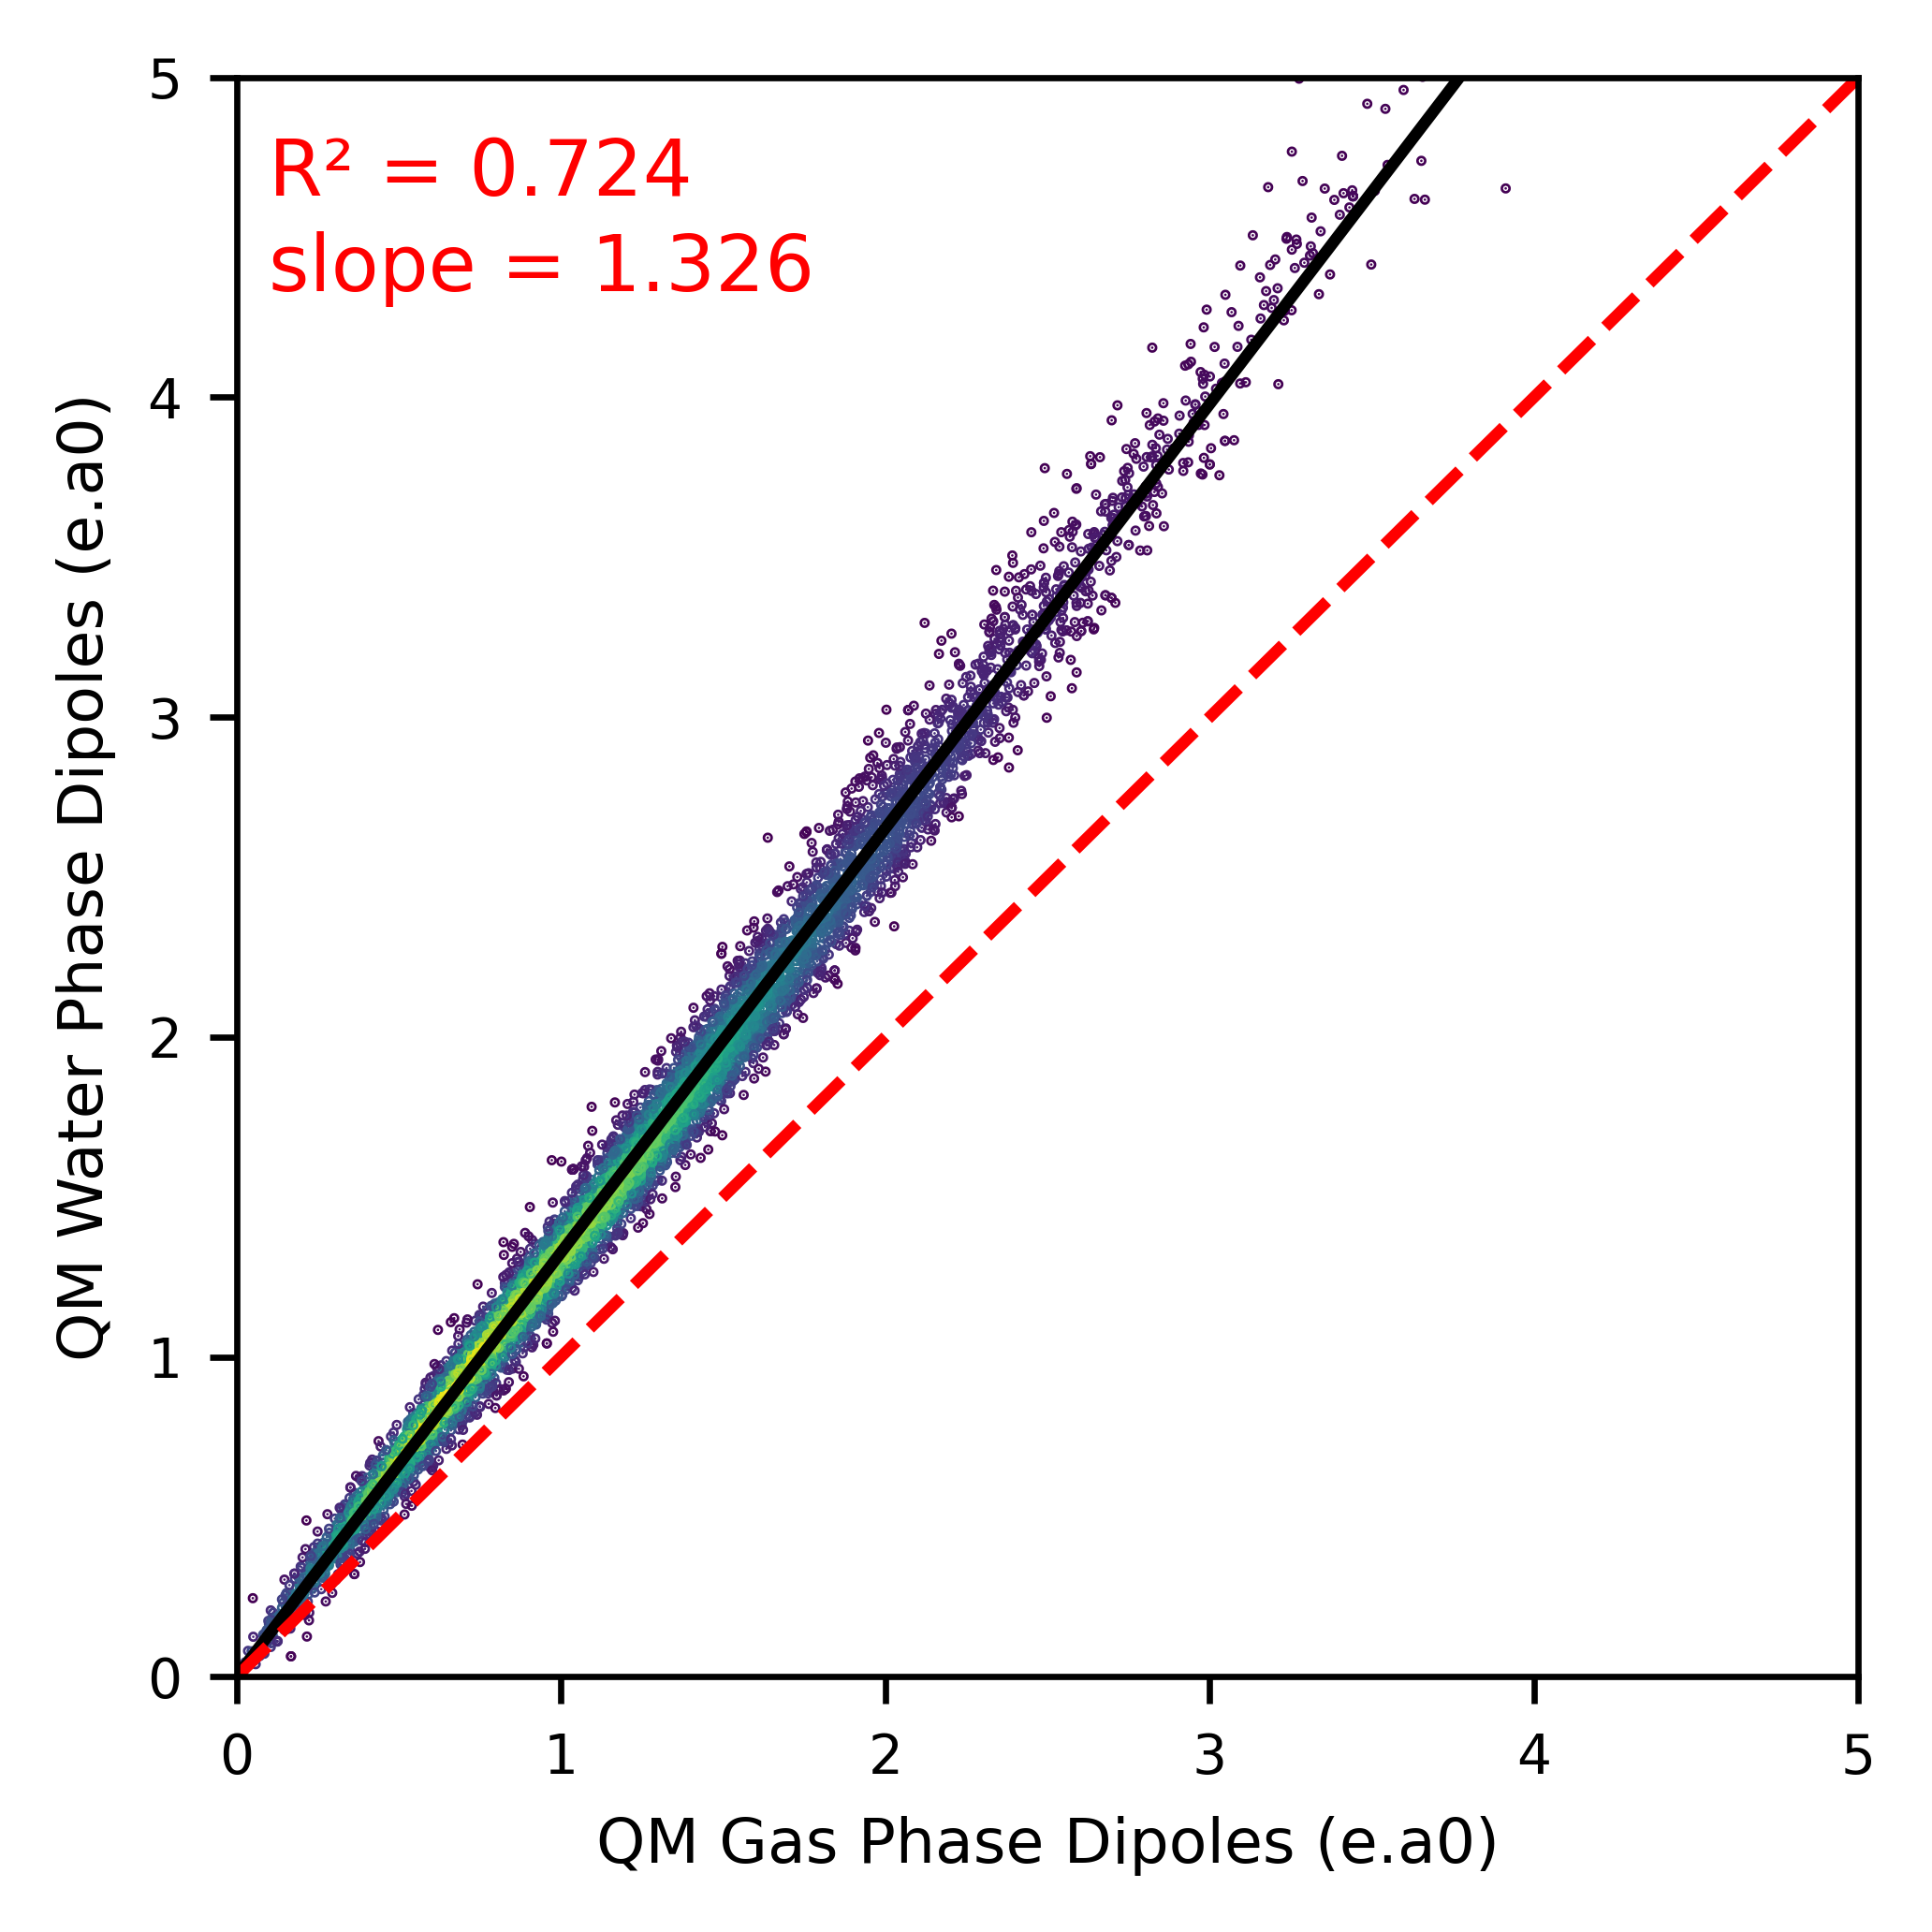

Slope of the best fit line constrained to pass through (0,0): 1.3261905020029818


In [30]:
matplotlib.rcParams.update({
    "font.size"       : 10,
    "axes.labelsize"  : 8,
    "axes.titlesize"  : 8,
    "xtick.labelsize" : 7,
    "ytick.labelsize" : 7,
})

# Load data
df_water = pd.read_parquet('./test_water_esp_model.parquet') 
df_gas = pd.read_parquet('./test_gas_esp_model.parquet')

#remove charged species
df_gas = df_gas[~df_gas.apply(filter_charged, axis=1)]
df_water = df_water[~df_water.apply(filter_charged, axis=1)]

# Align indices
df_gas.set_index('molblock', inplace=True)
df_water.set_index('molblock', inplace=True)
df_water = df_water.reindex(df_gas.index)

gas_model_dipoles = df_gas['qm_dipoles_magnitude']
water_model_dipoles = df_water['qm_dipoles_magnitude']

# Filter data for dipoles between 0 and 5
gas_ground_truth_filtered = gas_model_dipoles[(gas_model_dipoles >= 0) & (gas_model_dipoles <= 5)]
water_ground_truth_filtered = water_model_dipoles[(gas_model_dipoles >= 0) & (gas_model_dipoles <= 5)]

r2 = r2_score(water_ground_truth_filtered,gas_ground_truth_filtered)

# Calculate slope with the line constrained to pass through the origin
numerator = np.sum(gas_ground_truth_filtered * water_ground_truth_filtered)
denominator = np.sum(gas_ground_truth_filtered ** 2)
slope = numerator / denominator

# Define the new best fit line
fit_line = lambda x: slope * x

# Plot the scatter plot
xy = np.vstack([gas_ground_truth_filtered, water_ground_truth_filtered])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots(figsize=(3.54, 3.54), dpi=600)

ax.scatter(gas_ground_truth_filtered, water_ground_truth_filtered, s=0.1, c=z, label="Data")
ax.set_xlabel('QM Gas Phase Dipoles (e.a0)')
ax.set_ylabel('QM Water Phase Dipoles (e.a0)')

# Plot the new best fit line
x_vals = np.linspace(0, 5, 500)
ax.plot(x_vals, fit_line(x_vals), color='black', label=f'Best Fit Line (Slope: {slope:.2f})')

# Add equality line
ax.plot([0, 5], [0, 5], color='red', linestyle='--', label='y=x')

# Set plot limits
ax.set_xlim(0, 5)
ax.set_ylim(0, 5)

ax.text(0.1, 4.7, f'R² = {r2:.3f}', color='red', fontsize=10, ha='left', va='center')
ax.text(0.1, 4.4, f'slope = {slope:.3f}', color='red', fontsize=10, ha='left', va='center')


plt.tight_layout()
# plt.title(f"Scatter Plot with Best Fit Line (R²: {r2:.3f})")
plt.savefig('gas_vs_water_dipoles.png')
plt.show()

# Print slope
print(f"Slope of the best fit line constrained to pass through (0,0): {slope}")


Model gas vs dipole comparison

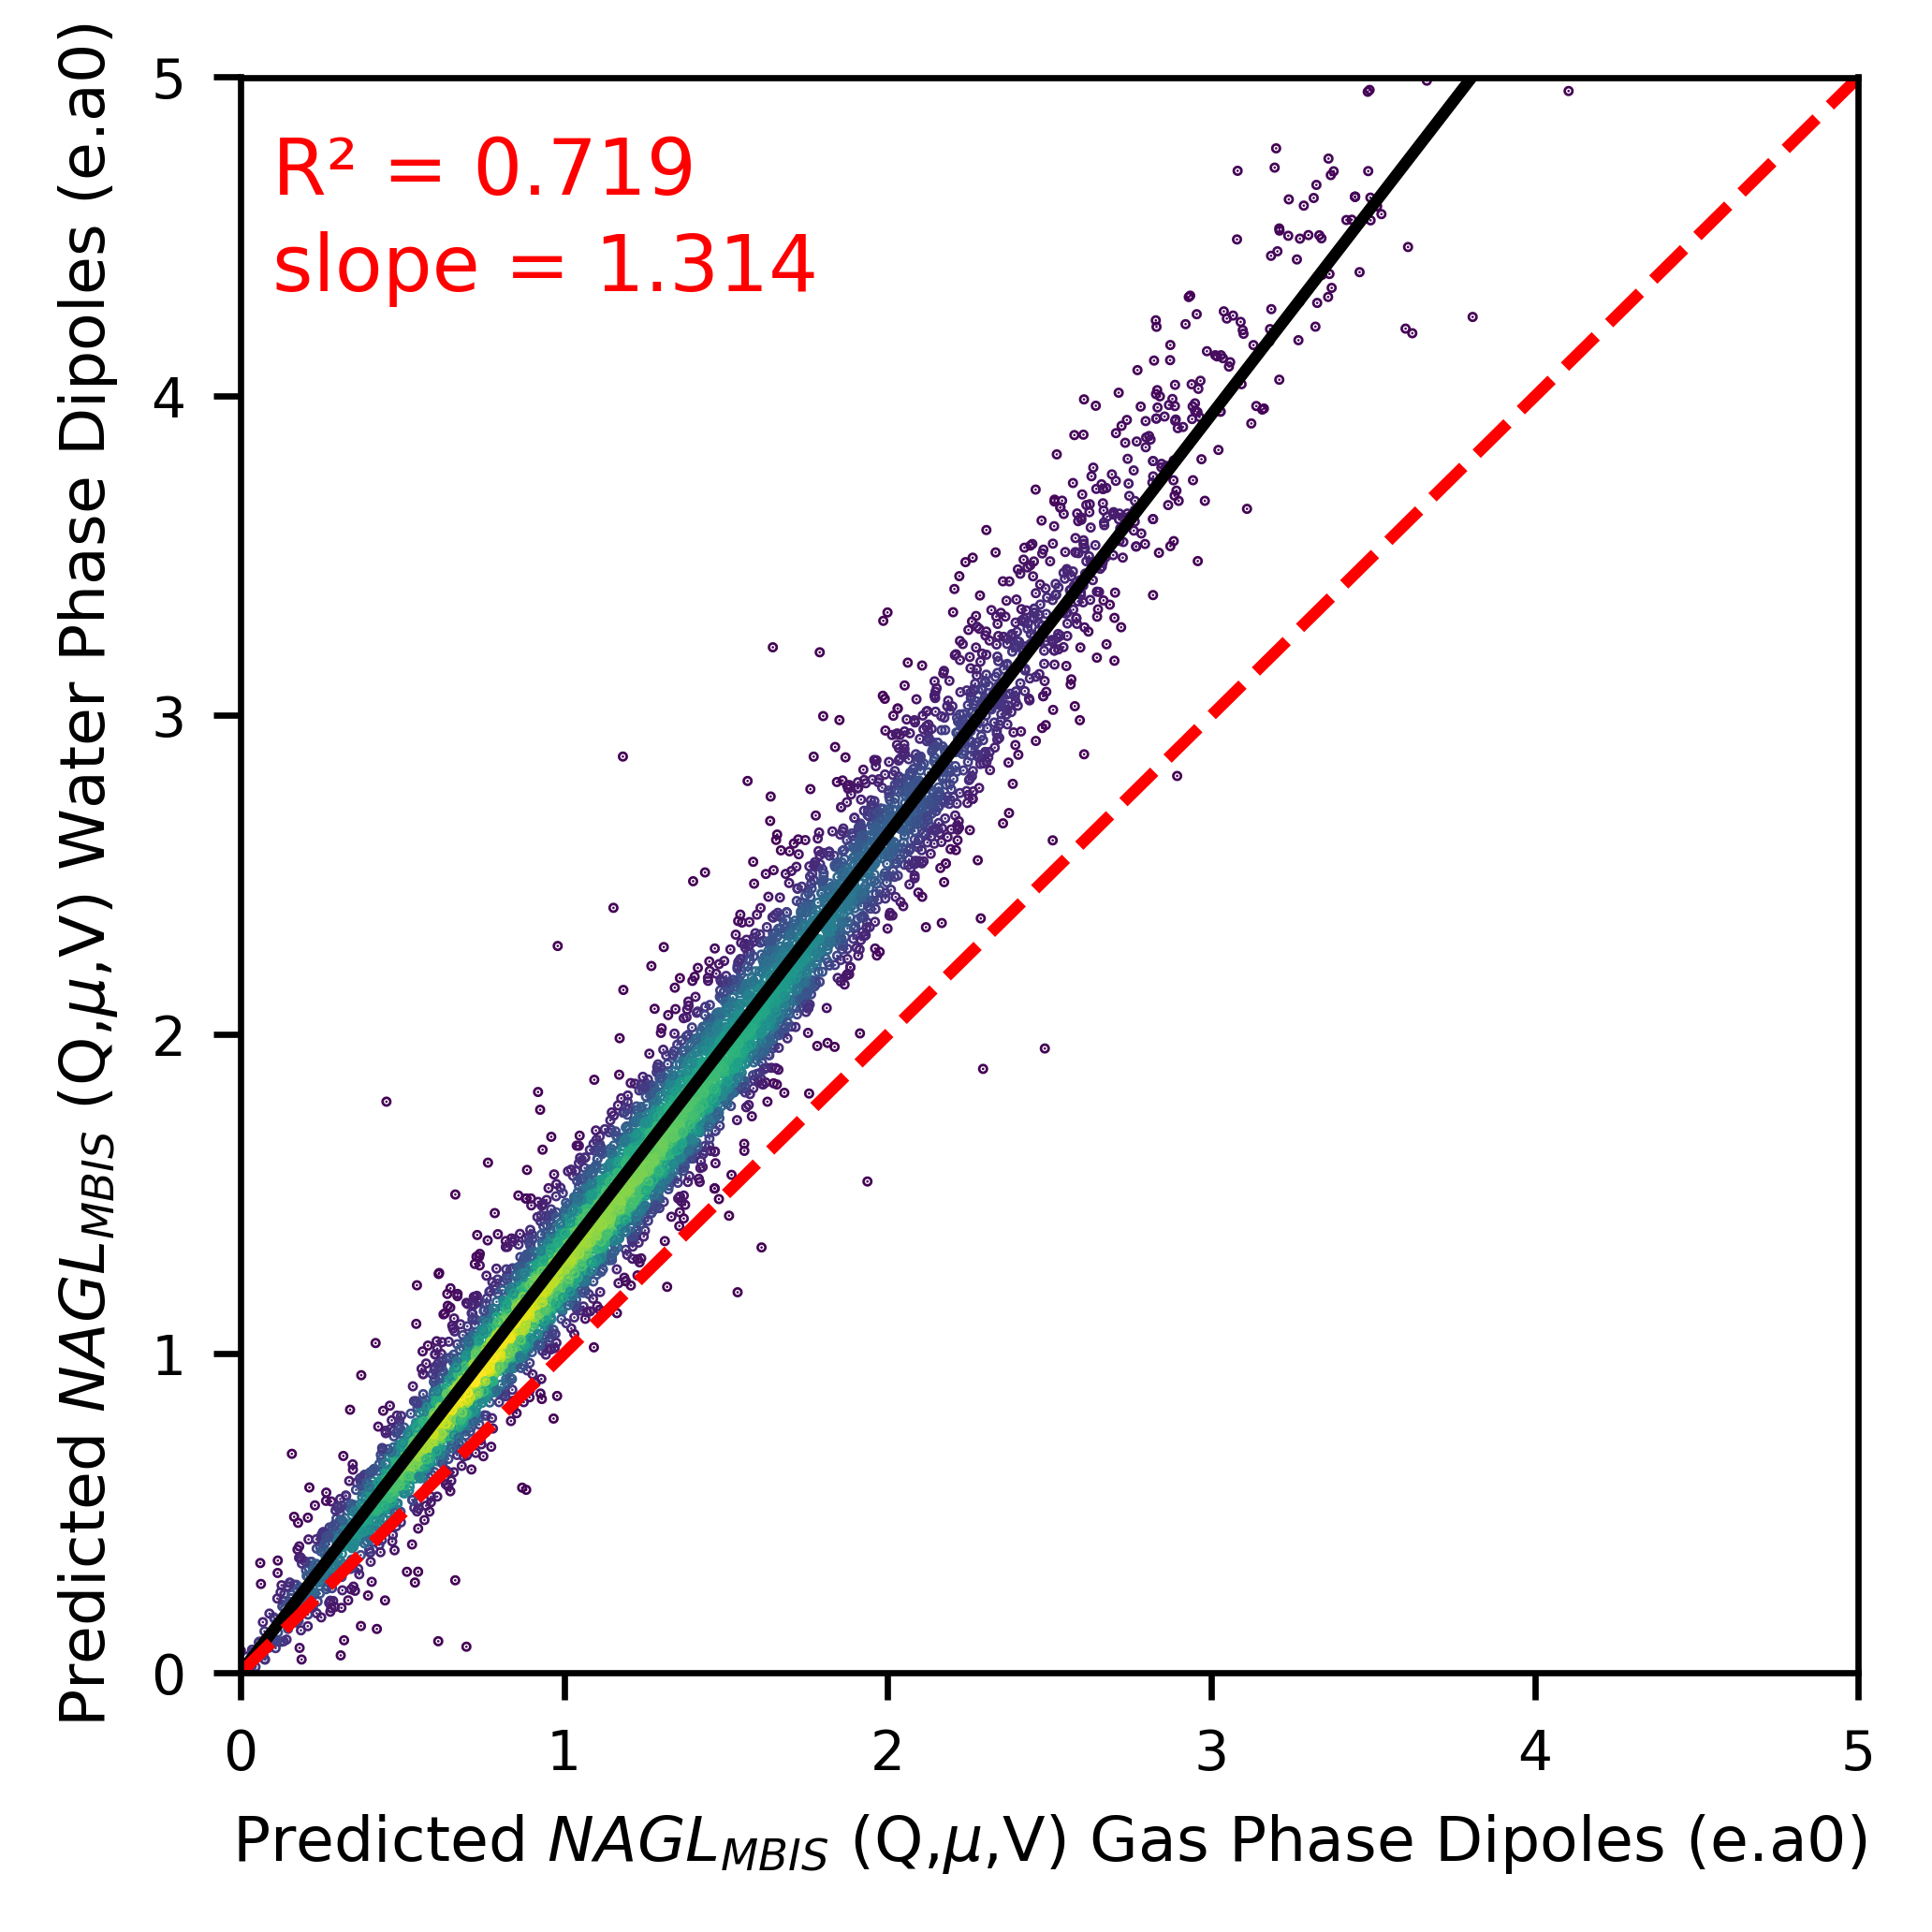

Slope of the best fit line constrained to pass through (0,0): 1.313966856468145


In [ ]:

# Load data
df_water = pd.read_parquet('./test_water_esp_model.parquet') 
df_gas = pd.read_parquet('./test_gas_esp_model.parquet')


#remove charged species
df_gas = df_gas[~df_gas.apply(filter_charged, axis=1)]
df_water = df_water[~df_water.apply(filter_charged, axis=1)]

# Align indices
df_gas.set_index('molblock', inplace=True)
df_water.set_index('molblock', inplace=True)
df_water = df_water.reindex(df_gas.index)

gas_model_dipoles = df_gas['esp_model_dipoles']
water_model_dipoles = df_water['esp_model_dipoles']

# Filter data for dipoles between 0 and 5
gas_filtered = gas_model_dipoles[(gas_model_dipoles >= 0) & (gas_model_dipoles <= 5)]
water_filtered = water_model_dipoles[(gas_model_dipoles >= 0) & (gas_model_dipoles <= 5)]

r2 = r2_score(water_filtered,gas_filtered)

# Calculate slope with the line constrained to pass through the origin
numerator = np.sum(gas_filtered * water_filtered)
denominator = np.sum(gas_filtered ** 2)
slope = numerator / denominator

# Define the new best fit line
fit_line = lambda x: slope * x

# Plot the scatter plot
xy = np.vstack([gas_filtered, water_filtered])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize=(3.54, 3.54), dpi=600)


ax.scatter(gas_filtered, water_filtered, s=0.1, c=z, label="Data")
ax.set_xlabel('Predicted $NAGL_{MBIS}$ (Q,$\mu$,V) Gas Phase Dipoles (e.a0)')
ax.set_ylabel('Predicted $NAGL_{MBIS}$ (Q,$\mu$,V) Water Phase Dipoles (e.a0)')

# Plot the new best fit line
x_vals = np.linspace(0, 5, 500)
ax.plot(x_vals, fit_line(x_vals), color='black', label=f'Best Fit Line (Slope: {slope:.2f})')

# Add equality line
ax.plot([0, 5], [0, 5], color='red', linestyle='--', label='y=x')

# Set plot limits
ax.set_xlim(0, 5)
ax.set_ylim(0, 5)

# plt.legend()
ax.text(0.1, 4.7, f'R² = {r2:.3f}', color='red', fontsize=10, ha='left', va='center')
ax.text(0.1, 4.4, f'slope = {slope:.3f}', color='red', fontsize=10, ha='left', va='center')
# fig.subplots_adjust(top=1.2)
plt.tight_layout()
plt.savefig('predicted_gas_vs_water_dipoles.png', bbox_inches='tight_layout')
# plt.gcf().subplots_adjust(top=1.15)

plt.show()

# Print slope
print(f"Slope of the best fit line constrained to pass through (0,0): {slope}")

Create a dataframe of the most divergent water vs gas dipoles

In [ ]:
# Calculate the difference between gas and water dipoles
data = gas_ground_truth_filtered - water_ground_truth_filtered

# Filter to include only cases where gas_dipole > water_dipole
filtered_data = data[data > 0]

# Sort the filtered Series by the absolute values of the differences
sorted_series = filtered_data.sort_values(ascending=False)

# Create a DataFrame from the sorted series
sorted_df = pd.DataFrame({
    'molblock': sorted_series.index,
    'qm_dipoles_magnitude': sorted_series.values
})

Display the most divergant dipoles

In [27]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from PIL import Image, ImageDraw, ImageFont
from io import BytesIO

d2d = Draw.MolDraw2DCairo(300,300)

def show_mol(d2d,mol,legend='',highlightAtoms=[]):
    d2d.DrawMolecule(mol,legend=legend, highlightAtoms=highlightAtoms)
    d2d.FinishDrawing()
    bio = BytesIO(d2d.GetDrawingText())

def draw_molecule_with_label(molblock, dipole, label, font_size=20):
    """Generate an image of a molecule with a dipole label."""
    mol = Chem.MolFromMolBlock(molblock)
    # img = Draw.MolToImage(mol, size=(300, 300))
  # Generate fresh 2D coordinates for the molecule
    AllChem.Compute2DCoords(mol)
    opts = Draw.rdMolDraw2D.MolDrawOptions()
    opts.bondLineWidth = 2  # Thicker bonds for clarity
    
    # Render the molecule to a PIL image
    img = Draw.MolToImage(mol, size=(300, 300), kekulize=True, options=opts)
    # Add label below the molecule image
    img_with_label = Image.new('RGB', (300, 350), "white")
    img_with_label.paste(img, (0, 0))
    
    draw = ImageDraw.Draw(img_with_label)
    font = ImageFont.load_default()
    text = f"{label}: {dipole:.3f} D"
    # text_width, text_height = draw.getsize(text)  # Corrected to use `getsize`
    text_width = 3
    text_height = 3
    text_position = ((300 - text_width) // 2, 310)  # Centered below the image
    draw.text(text_position, text, fill="black", font=font)
    
    return img_with_label

def create_side_by_side_images(sorted_df, gas_dipoles_series, water_dipoles_series):
    """Create a side-by-side visualization of molecules and their dipoles."""
    images = []
    for molblock in sorted_df['molblock'].head(10):  # Limit to top 10
        # Debugging: Check if molblock exists in both Series
        if molblock not in gas_dipoles_series.index or molblock not in water_dipoles_series.index:
            print(f"Molblock '{molblock}' not found in one of the dipole Series.")
            continue
        
        gas_dipole = gas_dipoles_series[molblock]
        water_dipole = water_dipoles_series[molblock]
        
        gas_image = draw_molecule_with_label(molblock, gas_dipole, "Gas")
        water_image = draw_molecule_with_label(molblock, water_dipole, "Water")
        
        # Combine the two images side by side
        combined_image = Image.new('RGB', (600, 350), "white")
        combined_image.paste(gas_image, (0, 0))
        combined_image.paste(water_image, (300, 0))
        
        images.append(combined_image)
    
    # Concatenate all combined images vertically
    final_image_height = sum(img.size[1] for img in images)
    final_image = Image.new('RGB', (600, final_image_height), "white")
    y_offset = 0
    for img in images:
        final_image.paste(img, (0, y_offset))
        y_offset += img.size[1]
    
    return final_image

# Generate the final image
final_image = create_side_by_side_images(sorted_df, gas_ground_truth_filtered, water_ground_truth_filtered)
final_image.show()  # To display the image


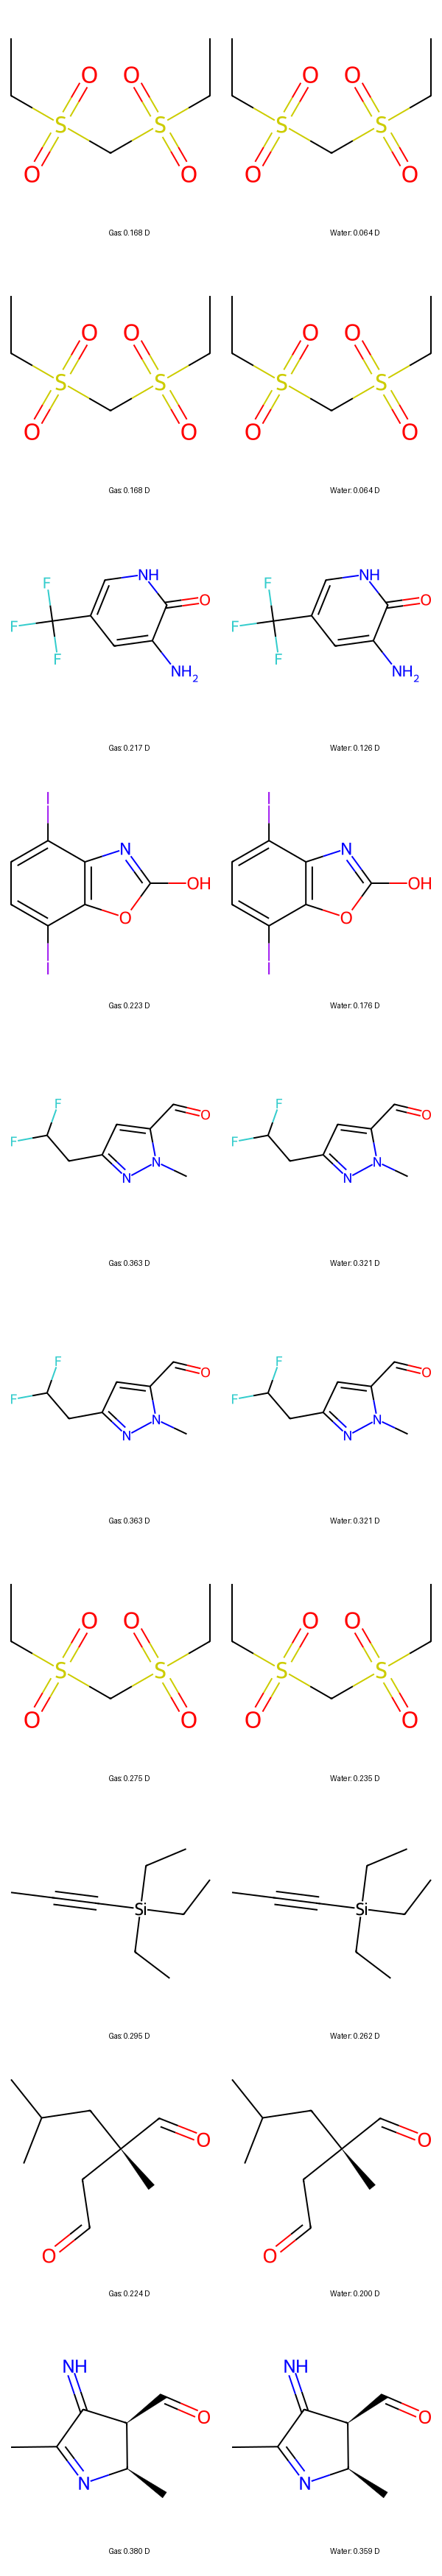

In [ ]:
#Ground Truth gas > water
final_image

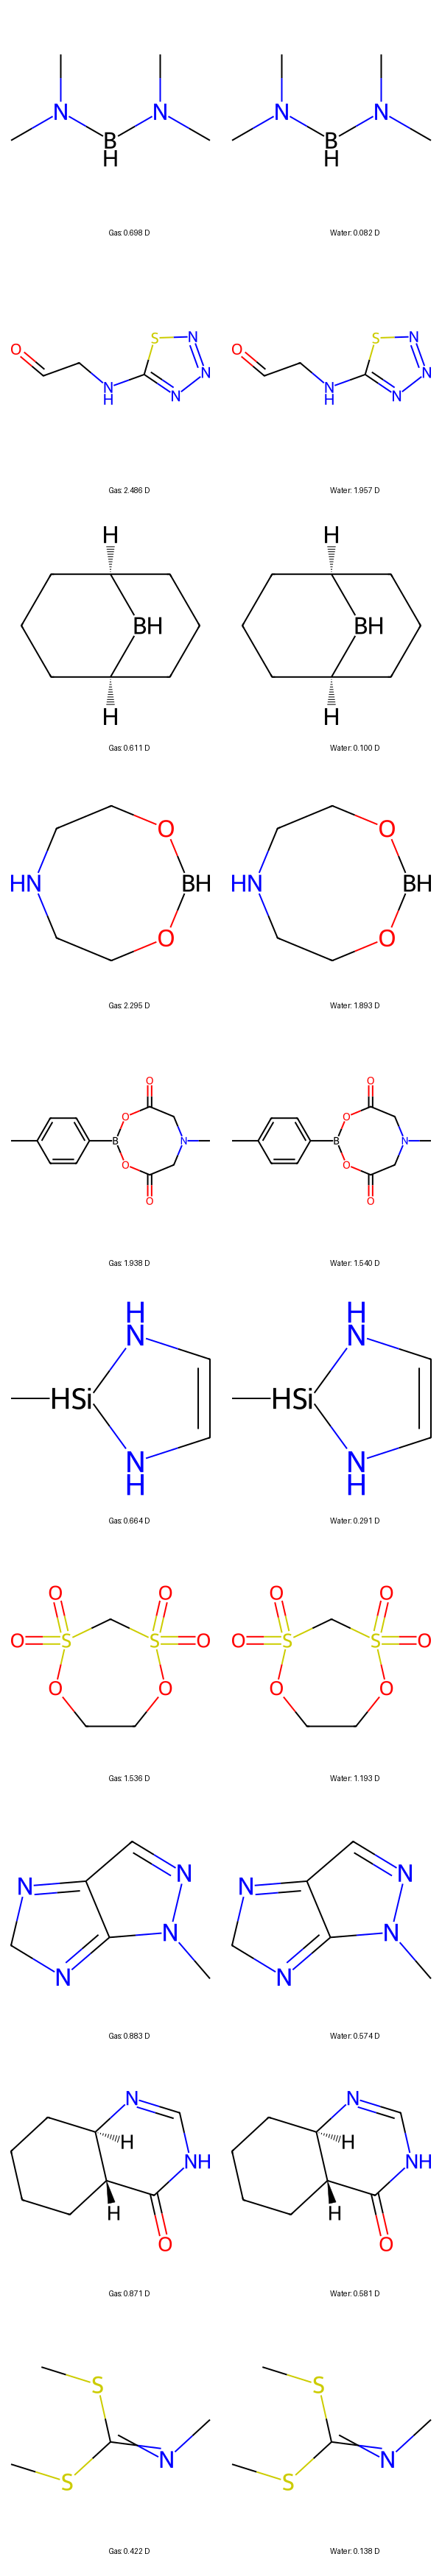

In [29]:
# Calculate the difference between gas and water dipoles
data = gas_filtered - water_filtered

# Filter to include only cases where gas_dipole > water_dipole
filtered_data = data[data > 0]

# Sort the filtered Series by the absolute values of the differences
sorted_series = filtered_data.sort_values(ascending=False)

# Create a DataFrame from the sorted series
sorted_df = pd.DataFrame({
    'molblock': sorted_series.index,
    'qm_dipoles_magnitude': sorted_series.values
})

# Display the result
final_image = create_side_by_side_images(sorted_df, gas_filtered, water_filtered)
final_image  # To display the image


Create an exploded dataframe of charges for element-by-element comparisons

In [42]:
def explode_charges(df, charge_columns, molecule_column='molecule'):
    rows = []
    for _, row in df.iterrows():
        charges_dict = {col: row[col] for col in charge_columns if row[col] is not None}
        n_charges = len(charges_dict[charge_columns[0]])  # Number of charges per molecule
        for i in range(n_charges):
            exploded_row = {col: charges_dict[col][i] for col in charge_columns}
            exploded_row[molecule_column] = row[molecule_column]
            exploded_row['element_index'] = i + 1  # Add index for the atom/element
            rows.append(exploded_row)
    return pd.DataFrame(rows)

# Define charge columns
charge_columns = ['mbis_charges', 'dipole_model_charges']

# Explode the DataFrame
exploded_df = explode_charges(df_esp, charge_columns)


In [33]:
exploded_df

,mbis_charges,charge_model_charges,molecule,element_index,element_symbol
0,0.047358,0.021070,[H:12][C:1]1=[C:2]2[C:3](=[N:10][N:11]1[H:15])...,1,C
1,-0.445321,-0.422686,[H:12][C:1]1=[C:2]2[C:3](=[N:10][N:11]1[H:15])...,2,C
2,0.596057,0.599397,[H:12][C:1]1=[C:2]2[C:3](=[N:10][N:11]1[H:15])...,3,C
3,-0.712835,-0.711618,[H:12][C:1]1=[C:2]2[C:3](=[N:10][N:11]1[H:15])...,4,N
4,0.966870,0.969259,[H:12][C:1]1=[C:2]2[C:3](=[N:10][N:11]1[H:15])...,5,C
...,...,...,...,...,...
1341835,0.025785,0.029688,[O:1]=[N:2][C:3]([C:4]1=[N:5][N:6]([H:12])[C:7...,9,I
1341836,0.161772,0.163071,[O:1]=[N:2][C:3]([C:4]1=[N:5][N:6]([H:12])[C:7...,10,H
1341837,0.163524,0.163071,[O:1]=[N:2][C:3]([C:4]1=[N:5][N:6]([H:12])[C:7...,11,H
1341838,0.352366,0.358224,[O:1]=[N:2][C:3]([C:4]1=[N:5][N:6]([H:12])[C:7...,12,H


Now we x

In [48]:

# Define a regex pattern that matches element tags like [C:3], [H:16], [N+:8], [O:12]
pattern = r"\[([A-Z][a-z]?)([+\-]?):(\d+)\]"

def get_element_symbol(row):
    mol_str = row['molecule']
    idx = row['element_index']
    
    # Find all matches in the molecule string
    matches = re.findall(pattern, mol_str)
    # matches will be a list of tuples like [('H', '', '16'), ('C', '', '3'), ('N', '+', '8'), ...]
    
    # Create a dictionary mapping index -> element symbol
    index_to_element = {}
    for elem, charge, number in matches:
        element_symbol = elem  # e.g., 'C', 'H', 'N'
        # Convert the number to int for easier lookup
        element_number = int(number)
        index_to_element[element_number] = element_symbol
    
    # Now find the element symbol for the given element_index
    return index_to_element.get(idx, None)

# Apply the function to each row
exploded_df['element_symbol'] = exploded_df.apply(get_element_symbol, axis=1)
exploded_df

,mbis_charges,dipole_model_charges,molecule,element_index,element_symbol
0,0.047358,0.025527,[H:12][C:1]1=[C:2]2[C:3](=[N:10][N:11]1[H:15])...,1,C
1,-0.445321,-0.437377,[H:12][C:1]1=[C:2]2[C:3](=[N:10][N:11]1[H:15])...,2,C
2,0.596057,0.612465,[H:12][C:1]1=[C:2]2[C:3](=[N:10][N:11]1[H:15])...,3,C
3,-0.712835,-0.702743,[H:12][C:1]1=[C:2]2[C:3](=[N:10][N:11]1[H:15])...,4,N
4,0.966870,0.983043,[H:12][C:1]1=[C:2]2[C:3](=[N:10][N:11]1[H:15])...,5,C
...,...,...,...,...,...
1341835,0.025785,0.026213,[O:1]=[N:2][C:3]([C:4]1=[N:5][N:6]([H:12])[C:7...,9,I
1341836,0.161772,0.168052,[O:1]=[N:2][C:3]([C:4]1=[N:5][N:6]([H:12])[C:7...,10,H
1341837,0.163524,0.168052,[O:1]=[N:2][C:3]([C:4]1=[N:5][N:6]([H:12])[C:7...,11,H
1341838,0.352366,0.351872,[O:1]=[N:2][C:3]([C:4]1=[N:5][N:6]([H:12])[C:7...,12,H


Plot the element-by-element comparisons

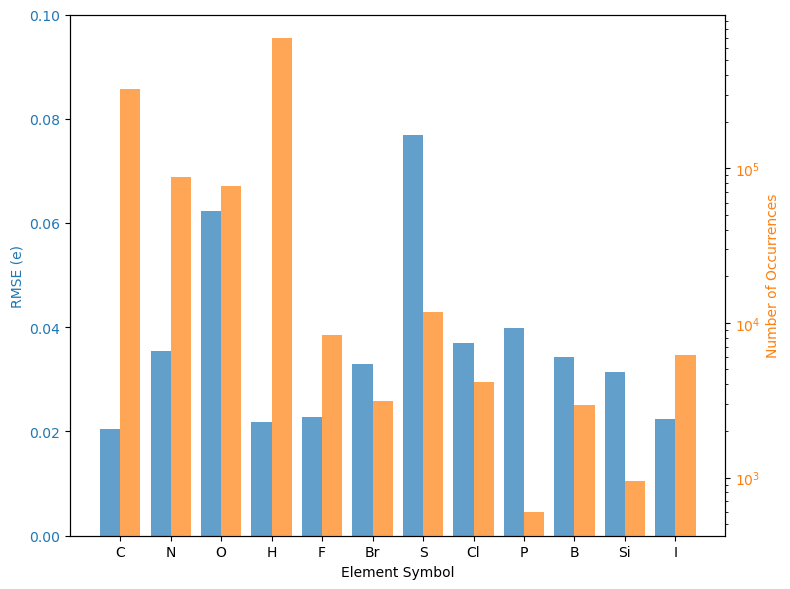

In [50]:

charge_model = 'dipole_model_charges'

def calculate_rmse(element, df):
    # Filter the dataframe for the chosen element
    df_element = df[df['element_symbol'] == element]
    
    # Convert to numpy arrays directly, assuming these columns contain scalar floats
    mbis_array = df_element['mbis_charges'].to_numpy(dtype=float)
    esp_array = df_element[charge_model].to_numpy(dtype=float)
    
    # Compute RMSE
    rmse = np.sqrt(np.mean((mbis_array - esp_array)**2))
    number_of_occurences =  len(mbis_array)
    return rmse, number_of_occurences

unique_elements = [el for el in exploded_df['element_symbol'].unique() if el is not None]

rmses = {}
no_occurences = {}
for element in unique_elements:
    rmse, number_of_occurrence = calculate_rmse(element, exploded_df)
    rmses[element] = rmse
    no_occurences[element] = number_of_occurrence

# Now all these have matching lengths:
elements = list(rmses.keys())  # length N
rmse_values = list(rmses.values())  # length N
occurrences_values = [no_occurences[el] for el in elements]  # length N

x = np.arange(len(elements))  # length N
# Create x positions for the bars
x = np.arange(len(unique_elements))
width = 0.4  # width of each bar

fig, ax1 = plt.subplots(figsize=(8, 6))

# Create the second y-axis
ax2 = ax1.twinx()

# Plot RMSE (left y-axis) - shift by -width/2
ax1.bar(x - width/2, rmse_values, width=width, color='C0', alpha=0.7, label='RMSE')
ax1.set_ylabel('RMSE (e)', color='C0')
ax1.set_ylim(0,0.10)
ax1.tick_params(axis='y', labelcolor='C0')

# Plot occurrences (right y-axis) - shift by +width/2
ax2.bar(x + width/2, occurrences_values, width=width, color='C1', alpha=0.7, label='Occurrences')
ax2.set_ylabel('Number of Occurrences', color='C1')
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='C1')

# Set x-ticks and labels
ax1.set_xticks(x)
ax1.set_xticklabels(elements)
ax1.set_xlabel('Element Symbol')

# Adjust spacing
plt.tight_layout()
plt.savefig('water_model_esp_errors_by_element_test.png', dpi=600)
plt.show()
